# PARABOLA

In [1]:
%matplotlib inline
import matplotlib
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, shapiro, anderson
colors_ = ['firebrick', 'darkgreen', 'navy', 'm', 'deepskyblue', 'goldenrod', 'black', 'grey']

In [2]:
from exploration.data.data import load_sim_h5_v2 as load_sim_h5
from exploration.data.PlotTools import *
from exploration.algorithm.utils.logging import read_config_log

In [3]:
def create_dict(groups_k):
    return {k[0] + '&' + k[1]: [] for k in groups_k}

def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,sz,color='b'):
    plt.sca(ax)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = color)
        
def get_stat_test(dict_):
    thresh = []
    values  = []
    for key in dict_.keys():
        if 'autonomous' in key:
            continue
        values += [dict_[key]]
        key = key.split('&')
        key[0] = key[0].replace('_','.')
        thresh += [float(key[0])]

    return pearsonr(thresh, values)
    
   

In [21]:
directories = ['parabola_experiment_thesis_chap_5/',\
               'parabola_experiment_thesis_chap_6_0_99/',\
               'parabola_experiment_thesis_chap_6_1_0/']

n_samples = 16200

# Group by:
mode_ops = ['social', 'social_no_thresh']
type_ops = ['simple','proprio']

groups_k = list(itertools.product(type_ops, mode_ops)) + list(itertools.product(['proprio'],['autonomous']))

#container for error
means_e = create_dict(groups_k)
means_av_e = create_dict(groups_k)

#container for social error
means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)
means_std_s = create_dict(groups_k)


#container for whole evaluation error 
means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)
means_std_w = create_dict(groups_k)

#container for interactions social eval
means_inter_s = create_dict(groups_k)
means_inter_av_s = create_dict(groups_k)
stds_inter_av_s = create_dict(groups_k)

#container for interactions whole eval
means_inter_w = create_dict(groups_k)
means_inter_av_w = create_dict(groups_k)
stds_inter_av_w = create_dict(groups_k)

#container for acomulated collisions
coll_e = create_dict(groups_k)
coll_av_e = create_dict(groups_k)

#container for collisions in social evaluation (not used)
coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)
coll_std_s = create_dict(groups_k)

#container for collisions in whole evaluation (not used)
coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)
coll_std_w = create_dict(groups_k)

#container for interactions data 
inter = create_dict(groups_k)
inter_av = create_dict(groups_k)
inter_std = create_dict(groups_k)

#container for errors
error_ev_social = create_dict(groups_k)
error_ev_social_av = create_dict(groups_k)

error_ev_whole = create_dict(groups_k)
error_ev_whole_av = create_dict(groups_k)

#container for standar deviations
std_ev_social = create_dict(groups_k)
std_ev_whole = create_dict(groups_k)

#container for competence during exploration
comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)

# Constraint violations during exploration
cons_ev_whole = create_dict(groups_k)
cons_ev_whole_av = create_dict(groups_k)
std_cons_ev_whole = create_dict(groups_k)

cons_ev_social = create_dict(groups_k)
cons_ev_social_av = create_dict(groups_k)
std_cons_ev_social = create_dict(groups_k)

for directory in directories:
    data_files = os.listdir(directory)
    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)

        if '1_0' in directory:
            conf['mode'] = conf['mode'] + '_no_thresh'
        
        data,foo = load_sim_h5(data_file)
        interaction_data = data.social.data.as_matrix(columns=None)
        interactions = np.zeros((n_samples,))
        interactions[~np.isnan(interaction_data[:n_samples, 0])] = 1

        social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'eval_social__Social_sensor_eva_valset.h5'))
        whole_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'eval_whole__Whole_sensor_eva_valset.h5'))

        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)

        s_con_v = social_data.cons.data.as_matrix()


        wh_error_ = np.linalg.norm(whole_data.sensor_goal.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        wh_con_v = whole_data.cons.data.as_matrix()

        e_con_v = data.cons.data.as_matrix()



        error_ = np.linalg.norm(data.sensor_goal.data.as_matrix() -
                                          data.sensor.data.as_matrix(), axis=1)

        error_ss_ = np.linalg.norm(data.somato_goal.data.as_matrix() -
                                  data.somato.data.as_matrix(), axis=1)


        eva_errors_social = []
        with open(data_file.replace('sim_data.h5', '_Social_eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                line.replace('\r', '')
                eva_errors_str = line.split(': ')
                eva_errors_social += [float(eva_errors_str[1])]

        eva_errors_whole = []
        with open(data_file.replace('sim_data.h5', '_Whole_eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                line.replace('\r', '')
                eva_errors_str = line.split(': ')
                eva_errors_whole += [float(eva_errors_str[1])]

        eva_cons_whole = []
        with open(data_file.replace('sim_data.h5', '_Whole_eval_cons.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                line.replace('\r', '')
                eva_cons_str = line.split(': ')
                #In the newes version the ratio is returned already divided by the len of the eval dataset
                eva_cons_whole += [float(eva_cons_str[1])]
                    
        eva_cons_social = []
        with open(data_file.replace('sim_data.h5', '_Social_eval_cons.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                line.replace('\r', '')
                eva_cons_str = line.split(': ')
                #In the newes version the ratio is returned already divided by the len of the eval dataset
                eva_cons_social += [float(eva_cons_str[1])]
                    

        means_s[conf['type'] + '&' + conf['mode']] += [np.mean(s_error_)]
        means_w[conf['type'] + '&' + conf['mode']] += [np.mean(wh_error_)]

        coll_s[conf['type'] + '&' + conf['mode']] += [np.mean(s_con_v)]
        coll_w[conf['type'] + '&' + conf['mode']] += [np.mean(wh_con_v)]
        coll_e[conf['type'] + '&' + conf['mode']] += [e_con_v[:n_samples]]

        inter[conf['type'] + '&' + conf['mode']] += [interactions]

        error_ev_social[conf['type'] + '&' + conf['mode']] += [eva_errors_social]
        error_ev_whole[conf['type'] + '&' + conf['mode']] += [eva_errors_whole]

        cons_ev_whole[conf['type'] + '&' + conf['mode']] += [eva_cons_whole]
        cons_ev_social[conf['type'] + '&' + conf['mode']] += [eva_cons_social]

        comp_w[conf['type'] + '&' + conf['mode']] += [error_[:n_samples]]

legend = []
max_std_social = 0
max_std_whole = 0
max_std_cons_whole = 0
max_std_cons_social = 0
for i, k in enumerate(groups_k):
    group = k[0] + '&' + k[1] 
    legend += [group]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))
    means_std_s[group] = np.std(np.array(means_s[group]))
    means_std_w[group] = np.std(np.array(means_w[group]))
    
    coll_av_e[group] = np.mean(np.array(coll_e[group]), axis=0)
    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)
    coll_std_s[group] = np.std(np.array(coll_s[group]), axis=0)
    coll_std_w[group] = np.std(np.array(coll_w[group]), axis=0)
    
    inter_av[group] = np.mean(np.array(inter[group]), axis=0)
    inter_std[group] = np.std(np.array(inter[group]), axis=0)
    
    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)
    #wh_comp_av_w[group] = np.mean(np.array(wh_comp_w[group]), axis=0)
    
    error_ev_social_av[group] = np.mean(np.array(error_ev_social[group]), axis=0)
    error_ev_whole_av[group] = np.mean(np.array(error_ev_whole[group]), axis=0)

    cons_ev_whole_av[group] = np.mean(np.array(cons_ev_whole[group]), axis=0)
    cons_ev_social_av[group] = np.mean(np.array(cons_ev_social[group]), axis=0)

    std_ev_social[group] = np.std(np.array(error_ev_social[group]),axis=0)
    std_ev_whole[group] = np.std(np.array(error_ev_whole[group]),axis=0)
    std_cons_ev_whole[group] = np.std(np.array(cons_ev_whole[group]),axis=0)
    std_cons_ev_social[group] = np.std(np.array(cons_ev_social[group]),axis=0)
    max_std_social = max(max_std_social,max(std_ev_social[group].flatten()))
    max_std_whole = max(max_std_whole,max(std_ev_whole[group].flatten()))
    max_std_cons_whole = max(max_std_cons_whole,max(std_cons_ev_whole[group].flatten()))
    max_std_cons_social = max(max_std_cons_social,max(std_cons_ev_social[group].flatten()))
    
    
print(max_std_social)
print(max_std_whole)
print(max_std_cons_whole)

0.26254599202689716
0.29563303154786424
0.053499767305008224


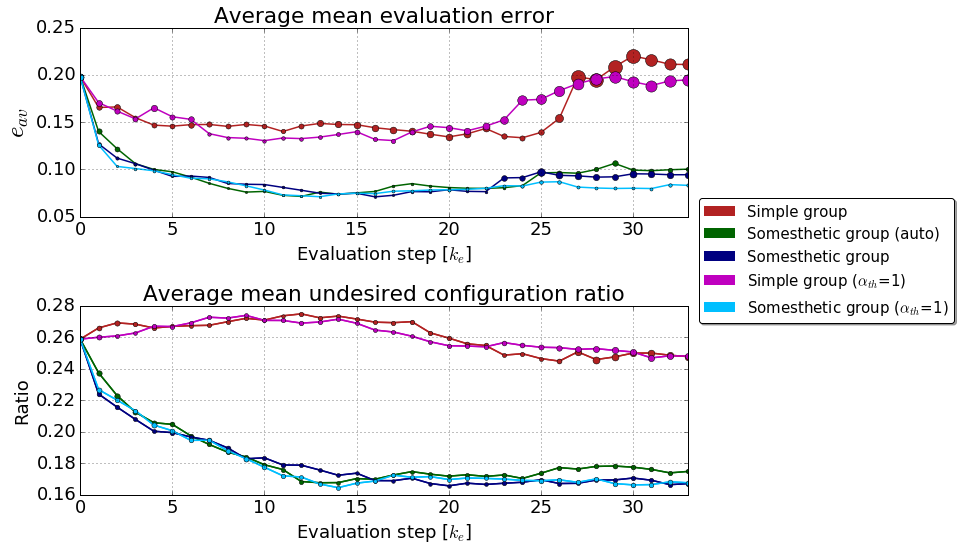

In [22]:
groups_to_plot = []
for group in groups_k:
    groups_to_plot += [group[0]+'&'+group[1]]
    
matplotlib.rcParams['figure.figsize'] = (10.0, 8.)
matplotlib.rcParams.update({'font.size': 18})

fig2, ax2 = plt.subplots(2,1)
plt.sca(ax2[0])
ax2[0].set_title('Average mean evaluation error')
for key, color in zip(error_ev_whole_av.keys(), colors_):
    if key not in groups_to_plot:
        continue
    data_plt = error_ev_whole_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
    ms = [(x/max_std_whole)*13 + 1 for x in std_ev_whole[key]]
    std_markers(ax2[0],error_ev_whole_av[key],'o',ms,color=color)

plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel('$e_{av}$', size=25)
ax2[0].set_xlim([0,len(data_plt)-1])
ax2[0].set_ylim([0.05,0.25])

plt.sca(ax2[1])
ax2[1].set_title('Average mean undesired configuration ratio')
for key, color in zip(cons_ev_whole_av.keys(), colors_):
    data_plt = cons_ev_whole_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
for key, color in zip(cons_ev_whole_av.keys(), colors_):
    data_plt = cons_ev_whole_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
    ms = [(x/max_std_cons_whole)*6 + 1 for x in std_cons_ev_whole[key]]
    std_markers(ax2[1],cons_ev_whole_av[key],'o',ms,color=color)

plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel(r'Ratio')
ax2[1].set_xlim([0,len(data_plt)-1])
# ax2[0,0].set_ylim([0.07,0.15])  

lds_ = []
for key, color in zip(error_ev_whole_av.keys(), colors_):
    key = key.replace('_','.')
    key = key.replace('&','  ')
    key = key.replace('proprio','Somesthetic group')
    key = key.replace(' autonomous','(auto)')
    key = key.replace('social','')
    key = key.replace('simple','Simple group')
    key = key.replace(' .no.thresh',r'($\alpha _{th}$=1)')
    lds_ += [key]

lgd2 = plt.legend(lds_,\
           ncol=1,loc='lower right', fontsize=15, bbox_to_anchor=(1.45, 0.87), #bbox_to_anchor=(hor,ver)
          fancybox=True, shadow=True)
for legobj in lgd2.legendHandles:
    legobj.set_linewidth(10.0)

for ax_ in ax2:
    ax_.grid(True)

plt.tight_layout()

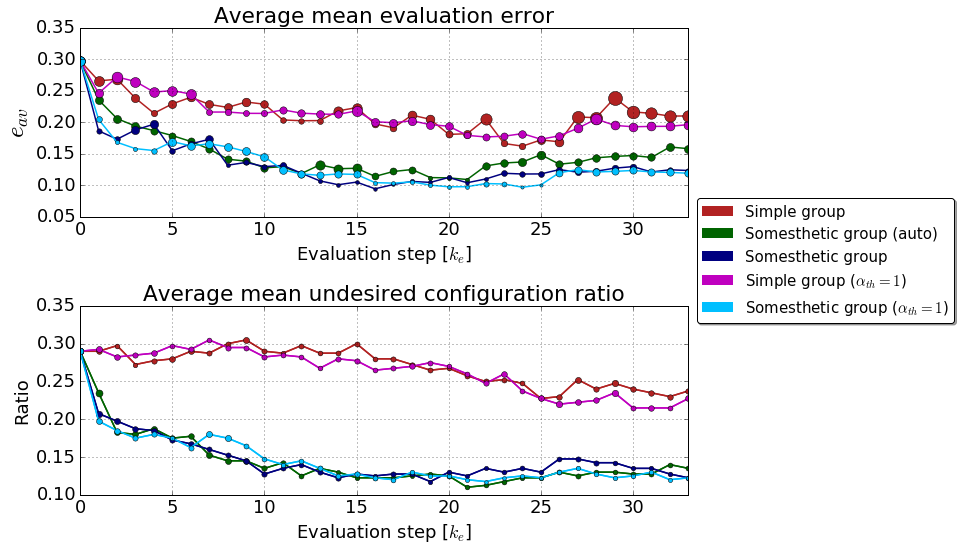

In [23]:
groups_to_plot = []
for group in groups_k:
    groups_to_plot += [group[0]+'&'+group[1]]
    
matplotlib.rcParams['figure.figsize'] = (10.0, 8.)
matplotlib.rcParams.update({'font.size': 18})

fig4, ax4 = plt.subplots(2,1)
plt.sca(ax4[0])
ax4[0].set_title('Average mean evaluation error')
for key, color in zip(error_ev_social_av.keys(), colors_):
    if key not in groups_to_plot:
        continue
    data_plt = error_ev_social_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
    ms = [(x/max_std_social)*13 + 1 for x in std_ev_social[key]]
    std_markers(ax4[0],error_ev_social_av[key],'o',ms,color=color)

plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel('$e_{av}$', size=25)
ax4[0].set_xlim([0,len(data_plt)-1])
ax4[0].set_ylim([0.05,0.35])

plt.sca(ax4[1])
ax4[1].set_title('Average mean undesired configuration ratio')
for key, color in zip(cons_ev_social_av.keys(), colors_):
    data_plt = cons_ev_social_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
for key, color in zip(cons_ev_social_av.keys(), colors_):
    data_plt = cons_ev_social_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
    ms = [(x/max_std_cons_social)*6 + 1 for x in std_cons_ev_social[key]]
    std_markers(ax4[1],cons_ev_social_av[key],'o',ms,color=color)

plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel(r'Ratio')
ax4[1].set_xlim([0,len(data_plt)-1])
# ax4[0,0].set_ylim([0.07,0.15])  

lds_ = []
for key, color in zip(error_ev_social_av.keys(), colors_):
    key = key.replace('_','.')
    key = key.replace('&','  ')
    key = key.replace('proprio','Somesthetic group')
    key = key.replace(' autonomous','(auto)')
    key = key.replace('social','')
    key = key.replace('simple','Simple group')
    key = key.replace(' .no.thresh',r'($\alpha _{th}=1$)')
    lds_ += [key]

lgd4 = plt.legend(lds_,\
           ncol=1,loc='lower right', fontsize=15, bbox_to_anchor=(1.45, 0.87), #bbox_to_anchor=(hor,ver)
          fancybox=True, shadow=True)
for legobj in lgd4.legendHandles:
    legobj.set_linewidth(10.0)

for ax_ in ax4:
    ax_.grid(True)

plt.tight_layout()

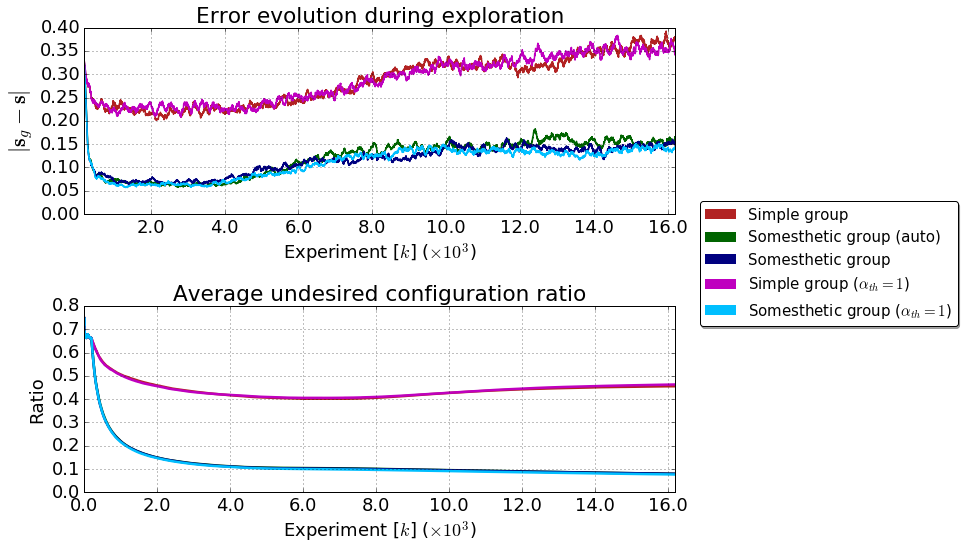

In [24]:
fig3, ax3 = plt.subplots(2,1)
plt.sca(ax3[0])
ax3[0].set_title('Error evolution during exploration')
win_sz=100
for key, color in zip(error_ev_whole_av.keys(), colors_):   
    data_plt = moving_av(comp_av_w[key],win_sz)
    plt.plot(data_plt, linestyle='-', marker='', lw = 1.5, color=color)
plt.xlabel(r'Experiment [$k$] ($\times 10^3$)')
plt.ylabel(r'$|\mathbf{s}_g-\mathbf{s}|$', size=22)
ax3[0].set_xlim([200,n_samples+1])
ax3[0].set_ylim([0,0.4])
ticks = ax3[0].get_xticks()*10**-3
ax3[0].set_xticklabels(ticks)

plt.sca(ax3[1])
ax3[1].set_title('Average undesired configuration ratio')
for key, color in zip(error_ev_whole_av.keys(), colors_):
    if key not in groups_to_plot:
        continue
    data_plt = incremental_mean(coll_av_e[key])
    if 'auto123' in key:
        plt.plot(data_plt, linestyle='--', marker='',lw = 2.5,color=color)    
    else:
        plt.plot(data_plt, linestyle='-', marker='',lw = 2.5,color=color)


plt.xlabel(r'Experiment [$k$] ($\times 10^3$)')
plt.ylabel('Ratio')
ax3[1].set_xlim([0,n_samples+1])
ax3[1].set_ylim([0,0.8])
ticks = ax3[1].get_xticks()*10**-3
ax3[1].set_xticklabels(ticks)


lds_ = []
for key, color in zip(error_ev_whole_av.keys(), colors_):
    key = key.replace('_','.')
    key = key.replace('&','  ')
    key = key.replace('proprio','Somesthetic group')
    key = key.replace(' autonomous','(auto)')
    key = key.replace('social','')
    key = key.replace('simple','Simple group')
    key = key.replace(' .no.thresh',r'($\alpha _{th}=1$)')
    lds_ += [key]

lgd3 = plt.legend(lds_,\
           ncol=1,loc='lower right', fontsize=15, bbox_to_anchor=(1.49, 0.85), #bbox_to_anchor=(hor,ver)
          fancybox=True, shadow=True)
for legobj in lgd3.legendHandles:
    legobj.set_linewidth(10.0)

for ax_ in ax3:
    ax_.grid(True)

plt.tight_layout()

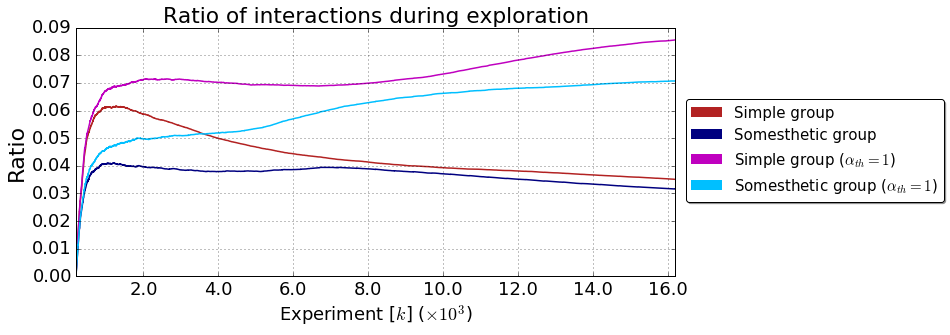

In [25]:
-

In [26]:
# fig2.savefig('C:/Users/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/parabola_results_eval_whole.eps',\
#               format='eps', dpi=1000, bbox_extra_artists=(lgd2,), bbox_inches='tight')
# fig4.savefig('C:/Users/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/parabola_results_eval_social.eps',\
#               format='eps', dpi=1000, bbox_extra_artists=(lgd4,), bbox_inches='tight')
# fig3.savefig('C:/Users/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/parabola_results_explo.eps',\
#               format='eps', dpi=1000, bbox_extra_artists=(lgd3,), bbox_inches='tight')
fig2.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/parabola_results_eval_whole.eps',\
              format='eps', dpi=1000, bbox_extra_artists=(lgd2,), bbox_inches='tight')
fig4.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/parabola_results_eval_social.eps',\
              format='eps', dpi=1000, bbox_extra_artists=(lgd4,), bbox_inches='tight')
fig3.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/parabola_results_explo.eps',\
              format='eps', dpi=1000, bbox_extra_artists=(lgd3,), bbox_inches='tight')
fig5.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/parabola_results_inter.eps',\
              format='eps', dpi=1000, bbox_extra_artists=(lgd5,), bbox_inches='tight')

In [47]:
print(np.argmin(error_ev_whole_av['proprio&autonomous']))
print np.argmin(error_ev_whole_av['simple&social_no_thresh'])
print np.argmin(error_ev_whole_av['proprio&social_no_thresh'])
print np.argmin(error_ev_whole_av['simple&social'])
print np.argmin(error_ev_whole_av['proprio&social'])

12
10
13
24
16


In [48]:
print(error_ev_whole_av['proprio&autonomous'][np.argmin(error_ev_whole_av['proprio&autonomous'])])
print std_ev_whole['proprio&autonomous'][np.argmin(error_ev_whole_av['proprio&autonomous'])]
print error_ev_whole_av['simple&social_no_thresh'][np.argmin(error_ev_whole_av['simple&social_no_thresh'])]
print std_ev_whole['simple&social_no_thresh'][np.argmin(error_ev_whole_av['simple&social_no_thresh'])]
print error_ev_whole_av['proprio&social_no_thresh'][np.argmin(error_ev_whole_av['proprio&social_no_thresh'])]
print std_ev_whole['proprio&social_no_thresh'][np.argmin(error_ev_whole_av['proprio&social_no_thresh'])]
print error_ev_whole_av['simple&social'][np.argmin(error_ev_whole_av['simple&social'])]
print std_ev_whole['simple&social'][np.argmin(error_ev_whole_av['simple&social'])]
print error_ev_whole_av['proprio&social'][np.argmin(error_ev_whole_av['proprio&social'])]
print std_ev_whole['proprio&social'][np.argmin(error_ev_whole_av['proprio&social'])]

0.071275924840724
0.03206211092847796
0.13036485320978197
0.05664255157154009
0.070972669444786
0.03171150852044204
0.13344401281618398
0.09531109668220498
0.07083133164058002
0.027441970652289992


In [35]:
print cons_ev_whole_av['proprio&autonomous'][np.argmin(error_ev_whole_av['proprio&autonomous'])]
print std_cons_ev_whole['proprio&autonomous'][np.argmin(error_ev_whole_av['proprio&autonomous'])]
print cons_ev_whole_av['simple&social_no_thresh'][np.argmin(error_ev_whole_av['simple&social_no_thresh'])]
print std_cons_ev_whole['simple&social_no_thresh'][np.argmin(error_ev_whole_av['simple&social_no_thresh'])]
print cons_ev_whole_av['proprio&social_no_thresh'][np.argmin(error_ev_whole_av['proprio&social_no_thresh'])]
print std_cons_ev_whole['proprio&social_no_thresh'][np.argmin(error_ev_whole_av['proprio&social_no_thresh'])]
print cons_ev_whole_av['simple&social'][np.argmin(error_ev_whole_av['simple&social'])]
print std_cons_ev_whole['simple&social'][np.argmin(error_ev_whole_av['simple&social'])]
print cons_ev_whole_av['proprio&social'][np.argmin(error_ev_whole_av['proprio&social'])]
print std_cons_ev_whole['proprio&social'][np.argmin(error_ev_whole_av['proprio&social'])]

0.16843537414964
0.02891859769515076
0.27083900226756
0.027635239827543484
0.16684807256238
0.02743329363414576
0.24965986394563994
0.02926927349255184
0.16902494331066
0.024511664041790466


In [36]:
print np.argmin(error_ev_social_av['proprio&autonomous'])
print np.argmin(error_ev_social_av['simple&social_no_thresh'])
print np.argmin(error_ev_social_av['proprio&social_no_thresh'])
print np.argmin(error_ev_social_av['simple&social'])
print np.argmin(error_ev_social_av['proprio&social'])

21
25
24
24
16


In [37]:
print error_ev_social_av['proprio&autonomous'][np.argmin(error_ev_social_av['proprio&autonomous'])]
print std_ev_social['proprio&autonomous'][np.argmin(error_ev_social_av['proprio&autonomous'])]
print error_ev_social_av['simple&social_no_thresh'][np.argmin(error_ev_social_av['simple&social_no_thresh'])]
print std_ev_social['simple&social_no_thresh'][np.argmin(error_ev_social_av['simple&social_no_thresh'])]
print error_ev_social_av['proprio&social_no_thresh'][np.argmin(error_ev_social_av['proprio&social_no_thresh'])]
print std_ev_social['proprio&social_no_thresh'][np.argmin(error_ev_social_av['proprio&social_no_thresh'])]
print error_ev_social_av['simple&social'][np.argmin(error_ev_social_av['simple&social'])]
print std_ev_social['simple&social'][np.argmin(error_ev_social_av['simple&social'])]
print error_ev_social_av['proprio&social'][np.argmin(error_ev_social_av['proprio&social'])]
print std_ev_social['proprio&social'][np.argmin(error_ev_social_av['proprio&social'])]

0.10880984507226797
0.06769073358220763
0.17278655525899
0.12357448268781619
0.09655201356467004
0.043664638652041905
0.16177361892153005
0.11092512535812636
0.09406694280538799
0.05228555930533595


In [38]:
print cons_ev_social_av['proprio&autonomous'][np.argmin(error_ev_social_av['proprio&autonomous'])]
print std_cons_ev_social['proprio&autonomous'][np.argmin(error_ev_social_av['proprio&autonomous'])]
print cons_ev_social_av['simple&social_no_thresh'][np.argmin(error_ev_social_av['simple&social_no_thresh'])]
print std_cons_ev_social['simple&social_no_thresh'][np.argmin(error_ev_social_av['simple&social_no_thresh'])]
print cons_ev_social_av['proprio&social_no_thresh'][np.argmin(error_ev_social_av['proprio&social_no_thresh'])]
print std_cons_ev_social['proprio&social_no_thresh'][np.argmin(error_ev_social_av['proprio&social_no_thresh'])]
print cons_ev_social_av['simple&social'][np.argmin(error_ev_social_av['simple&social'])]
print std_cons_ev_social['simple&social'][np.argmin(error_ev_social_av['simple&social'])]
print cons_ev_social_av['proprio&social'][np.argmin(error_ev_social_av['proprio&social'])]
print std_cons_ev_social['proprio&social'][np.argmin(error_ev_social_av['proprio&social'])]

0.11
0.07762087348130009
0.2275
0.09902651160169175
0.125
0.06614378277661477
0.2475
0.08097067370350822
0.125
0.075


In [39]:
print incremental_mean(coll_av_e['proprio&autonomous'])[-1]
print incremental_mean(coll_av_e['simple&social_no_thresh'])[-1]
print incremental_mean(coll_av_e['proprio&social_no_thresh'])[-1]
print incremental_mean(coll_av_e['simple&social'])[-1]
print incremental_mean(coll_av_e['proprio&social'])[-1]

0.07924567901233012
0.46294444444447536
0.07658271604936785
0.45529382716051026
0.07960246913578636


In [53]:
print  np.mean(comp_av_w['proprio&autonomous'])
print  np.mean(comp_av_w['simple&social_no_thresh'])
print  np.mean(comp_av_w['proprio&social_no_thresh'])
print  np.mean(comp_av_w['simple&social'])
print  np.mean(comp_av_w['proprio&social'])

0.1507233795556405
0.31504710550304976
0.140215132059667
0.31360456914434487
0.1449418625913957


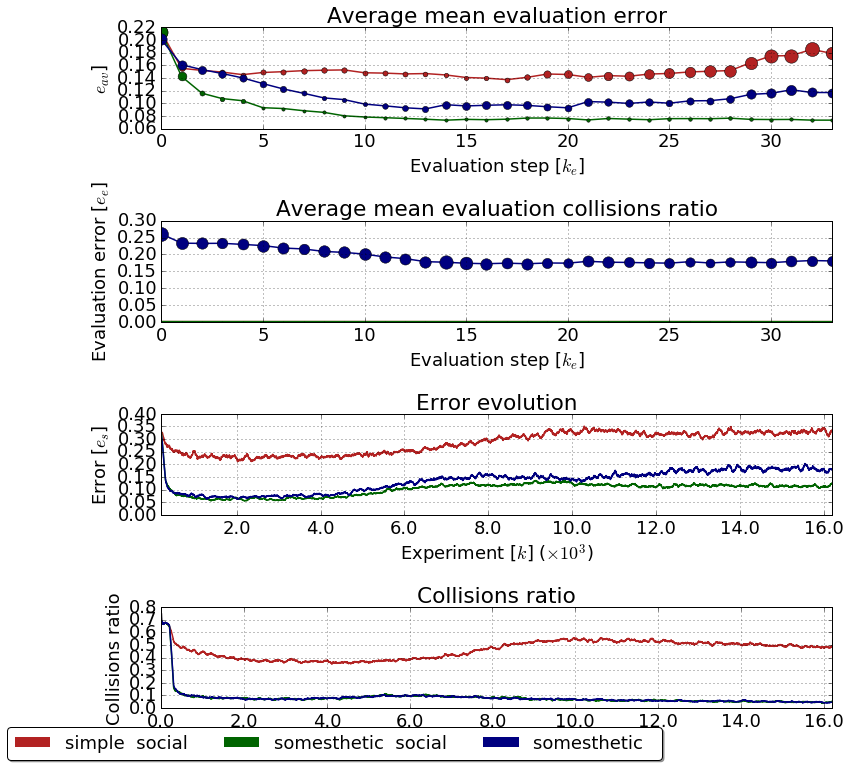

In [15]:
groups_to_plot = []
for group in groups_k:
    groups_to_plot += [group[0]+'&'+group[1]]

matplotlib.rcParams['figure.figsize'] = (11.0, 11.)
matplotlib.rcParams.update({'font.size': 18})

fig1, ax1 = plt.subplots(4,1)
plt.sca(ax1[0])
ax1[0].set_title('Average mean evaluation error')
for key, color in zip(error_ev_whole_av.keys(), colors_):
    if key not in groups_to_plot:
        continue
    data_plt = error_ev_whole_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
    ms = [(x/max_std_whole)*13 + 1 for x in std_ev_whole[key]]
    std_markers(ax1[0],error_ev_whole_av[key],'o',ms,color=color)

plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel('$e_{av}$]')
ax1[0].set_xlim([0,len(data_plt)-1])
# ax1[0,0].set_ylim([0.07,0.15])

plt.sca(ax1[1])
ax1[1].set_title('Average mean evaluation collisions ratio')
for key, color in zip(cons_ev_whole_av.keys(), colors_):
    data_plt = cons_ev_whole_av[key]
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
    ms = [(x/max_std_cons_whole)*13 + 1 for x in std_cons_ev_whole[key]]
    std_markers(ax1[1],cons_ev_whole_av[key],'o',ms,color=color)

plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel('Evaluation error [$e_e$]')
ax1[1].set_xlim([0,len(data_plt)-1])
# ax1[0,0].set_ylim([0.07,0.15])  
    
plt.sca(ax1[2])
ax1[2].set_title('Error evolution')
win_sz=100
# ax1[0,1].hold(True)
# plt.gca().set_color_cycle(None)
for key, color in zip(error_ev_whole_av.keys(), colors_):   
    data_plt = moving_av(comp_av_w[key],win_sz)
    plt.plot(data_plt, linestyle='-', marker='', lw = 1.5, color=color)
plt.xlabel(r'Experiment [$k$] ($\times 10^3$)')
plt.ylabel('Error [$e_s$]')
# plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
#            ncol=2,loc='lower right', fontsize=13)
ax1[2].set_xlim([200,n_samples+1])
ax1[2].set_ylim([0,0.4])
ticks = ax1[2].get_xticks()*10**-3
ax1[2].set_xticklabels(ticks)

plt.sca(ax1[3])
ax1[3].set_title('Collisions ratio')
#print('Collisions ratio')
# ax1[1,0].hold(True)
# plt.gca().set_color_cycle(None)
for key, color in zip(error_ev_whole_av.keys(), colors_):
    if key not in groups_to_plot:
        continue
    data_plt = moving_av(coll_av_e[key],win_sz)
    #print("{}: {}".format(key, data_plt[-1]))
#     if 'autonomous' in key:
#         plt.plot(data_plt, linestyle='-.', marker='',color=color)
#     else:
    plt.plot(data_plt, linestyle='-', marker='',lw = 1.5,color=color)

plt.xlabel(r'Experiment [$k$] ($\times 10^3$)')
plt.ylabel('Collisions ratio')
ax1[3].set_xlim([0,n_samples+1])
ax1[3].set_ylim([0,0.8])
ticks = ax1[3].get_xticks()*10**-3
ax1[3].set_xticklabels(ticks)


lds_ = []
for key, color in zip(error_ev_whole_av.keys(), colors_):
    key = key.replace('_','.')
    key = key.replace('&','  ')
    key = key.replace('proprio','somesthetic')
    key = key.replace('autonomous','')
    lds_ += [key]

lgd = plt.legend(lds_,\
           ncol=4,loc='lower right', fontsize=18, bbox_to_anchor=(0.76, -0.6), #bbox_to_anchor=(hor,ver)
          fancybox=True, shadow=True)
for legobj in lgd.legendHandles:
    legobj.set_linewidth(10.0)

for ax_ in ax1:
    ax_.grid(True)

plt.tight_layout()

In [53]:
for key, color in zip(error_ev_whole_av.keys(), colors_):
    print(key)
    print(np.mean(coll_av_e[key]))
    print(incremental_mean(coll_av_e[key])[-1])



simple&social
0.46123703703703706
0.46123703703705937
proprio&autonomous
0.0807777777777778
0.08077777777776117
proprio&social
0.08003950617283953
0.08003950617282302
simple&social_no_thresh
0.463262962962963
0.4632629629629958
proprio&social_no_thresh
0.07826543209876544
0.07826543209875014
